# Assignment 1: Computational Modelling Social Systems
## Paper No 7 from Excel Sheet

#### Title: "A simple model of global cascades on random networks"
##### Author: Duncan J. Watts
##### Affiliation: Department of Sociology, Columbia University
##### Publication: PNAS (Proceedings of the National Academy of Sciences), April 30, 2002
##### Communication: Through Murray Gell-Mann, Santa Fe Institute, February 14, 2002 (received for review May 29, 2001)

### Scope and Purpose

The authors provide a mathematical model to explain one common phenomenon that appears in diverse systems: how occasionally tiny initial jolts are capable of triggering massive, system-level cascades in networks. The phenomenon is seen in:

Cultural trends

Social movements and collective action

Diffusion of norms and innovations

Cascading failures in infrastructure networks

Stock market trends

Watts built this model to explain the "robust but fragile" nature of complex systems - why systems may appear to be stable in response to a large number of perturbations but suddenly exhibit huge, global disruptions from seemingly similar perturbations.

### Methodology

Watts created a mathematical model with:

A random graph of n agents
Each agent has a threshold φ drawn from distribution f(φ)
Each agent is connected to k neighbors with probability pk
All agents begin in state 0 (off)
A small subset (usually one node) is flipped to state 1, and the spread is observed

The study applies generating functions within graph theory to compute the conditions at which global cascades take place.

### Key Findings

Global cascades require that the subnetwork of vulnerable vertices must percolate throughout the entire network.
The cascade condition is derived as: 

G'₀(1) = Σk k(k-1)ρkpk = z, with G'₀ a generating function related to vulnerable vertices.

Two phase transitions characterize the "cascade window":

Lower boundary: Similar to ordinary percolation with power-law cascade size distribution
Upper boundary: Bimodally distributed with sudden, giant cascades

Different types of heterogeneity have opposite impacts:

Higher heterogeneity in thresholds increases the system's susceptibility
Higher heterogeneity in network degree reduces its susceptibility

In networks with highly skewed degree distributions, targeting high-degree nodes is much more effective for triggering cascades, but only in the low-connectivity regime.

### Key Elements for Implementation

##### Network Generation:

You'll need to create random networks with a specified degree distribution

Libraries like NetworkX are ideal for this (import networkx as nx)

For uniform random graphs: nx.erdos_renyi_graph(n, p)

For power-law networks: nx.configuration_model() with a power-law degree sequence


##### Agent Attributes:

Every node (agent) needs:

A state (0 or 1, inactive or active)

A threshold (φ) - either uniform or drawn from a distribution

Neighbors (specified by the network structure)


#### Simulation Dynamics:

Initialize all nodes to state 0

Activate a small seed (typically a single node)

Apply threshold rule: an agent flips to state 1 if proportion of neighbors in state 1 ≥ threshold

Update nodes in random asynchronous order


##### Parameters to Vary:

Network size (n)

Average degree (z)

Threshold distribution parameters (φ*)

Network type (uniform random, power-law, etc.)


##### Measurements:

Cascade size (proportion of network activated)

Frequency of global cascades

Size distribution of cascades

Time to reach steady state

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
import networkx as nx
import random
from collections import Counter
import time

In [13]:
class CascadeModel:
    """
    Implements the Duncan Watts threshold model of cascades on random networks
    """
    
    def __init__(self, n=10000, z=4, phi_star=0.18, threshold_type="uniform", threshold_std=0, 
                 network_type="uniform", power_law_alpha=2.5):
        """
        Initialize the cascade model with given parameters
        
        Parameters:
        -----------
        n : int
            Number of nodes in the network
        z : float
            Average degree of the network
        phi_star : float
            Mean threshold value
        threshold_type : str
            "uniform" - all nodes have same threshold
            "normal" - thresholds drawn from normal distribution with mean phi_star and std threshold_std
        threshold_std : float
            Standard deviation of threshold distribution (if threshold_type="normal")
        network_type : str
            "uniform" - Erdos-Renyi random graph
            "power_law" - Power-law degree distribution with exponent alpha
        power_law_alpha : float
            Exponent for power-law degree distribution
        """
        self.n = n
        self.z = z
        self.phi_star = phi_star
        self.threshold_type = threshold_type
        self.threshold_std = threshold_std
        self.network_type = network_type
        self.power_law_alpha = power_law_alpha
        
        # Initialize network and thresholds
        self.G = self._create_network()
        self.thresholds = self._assign_thresholds()
        
        # State will be initialized when running simulations
        self.state = None
        
    def _create_network(self):
        """Create network according to specified parameters"""
        if self.network_type == "uniform":
            # Erdos-Renyi random graph with expected average degree z
            p = self.z / (self.n - 1)
            G = nx.erdos_renyi_graph(self.n, p)
            return G
        
        elif self.network_type == "power_law":
            alpha = self.power_law_alpha
            k_min = 1  # Minimum degree
            
            # Generate random values from power law distribution
            sequence = np.random.power(alpha, self.n)
            sequence = 1 + (sequence * 10).astype(int)
            current_avg = np.mean(sequence)
            sequence = np.ceil(sequence * (self.z / current_avg)).astype(int)
            
            # Ensure even sum for configuration model
            if sum(sequence) % 2 == 1:
                sequence[0] += 1
                
            # Create graph with this degree sequence
            G = nx.configuration_model(sequence.tolist())
            
            # Remove self-loops and parallel edges
            G = nx.Graph(G)
            return G
        
    def _assign_thresholds(self):
        """Assign thresholds to each node"""
        thresholds = {}
        
        if self.threshold_type == "uniform":
            # All nodes have the same threshold
            for node in self.G.nodes():
                thresholds[node] = self.phi_star
                
        elif self.threshold_type == "normal":
            # Thresholds drawn from normal distribution, clipped to [0,1]
            for node in self.G.nodes():
                # Draw from normal distribution, but clip to [0,1]
                threshold = np.random.normal(self.phi_star, self.threshold_std)
                thresholds[node] = max(0, min(1, threshold))
                
        return thresholds
    
    def initialize_state(self, seed_nodes=None):
        """Initialize all nodes to state 0, except seed nodes set to 1"""
        self.state = {node: 0 for node in self.G.nodes()}
        
        if seed_nodes is None:
            # Select one random node as seed
            seed_nodes = [random.choice(list(self.G.nodes()))]
            
        for node in seed_nodes:
            self.state[node] = 1
            
        return seed_nodes
    
    def run_cascade(self, seed_nodes=None, max_iterations=100):
        """
        Run a cascade simulation from initial seed nodes
        
        Parameters:
        -----------
        seed_nodes : list
            Nodes to activate initially (if None, a random node is chosen)
        max_iterations : int
            Maximum number of iterations to prevent infinite loops
            
        Returns:
        --------
        final_state : dict
            Final state of each node (0 or 1)
        cascade_size : float
            Fraction of nodes activated
        time_steps : int
            Number of iterations until convergence
        """
        # Initialize states
        seed_nodes = self.initialize_state(seed_nodes)
        
        # Track active nodes in each round
        active_this_round = set(seed_nodes)
        time_steps = 0
        
        # Continue until no new activations or max iterations reached
        while active_this_round and time_steps < max_iterations:
            new_active = set()
            
            # Check each node in random order
            nodes_to_check = list(self.G.nodes())
            random.shuffle(nodes_to_check)
            
            for node in nodes_to_check:
                # Skip already active nodes
                if self.state[node] == 1:
                    continue
                    
                # Get neighbors
                neighbors = list(self.G.neighbors(node))
                if not neighbors:
                    continue  
                    
                active_neighbors = sum(self.state[neigh] == 1 for neigh in neighbors)
                fraction_active = active_neighbors / len(neighbors)
                
                if fraction_active >= self.thresholds[node]:
                    self.state[node] = 1
                    new_active.add(node)
            
            active_this_round = new_active
            time_steps += 1
        
        # Calculate cascade size
        cascade_size = sum(self.state.values()) / self.n
        
        return self.state, cascade_size, time_steps
    
    def identify_vulnerable_nodes(self):
        """
        Identify vulnerable nodes (those with threshold <= 1/k)
        
        Returns:
        --------
        vulnerable : set
            Set of vulnerable node IDs
        vulnerable_fraction : float
            Fraction of vulnerable nodes
        """
        vulnerable = set()
        
        for node in self.G.nodes():
            degree = self.G.degree(node)
            if degree == 0:
                continue  # Skip isolated nodes
                
            # A node is vulnerable if its threshold is <= 1/degree
            if self.thresholds[node] <= 1.0 / degree:
                vulnerable.add(node)
                
        return vulnerable, len(vulnerable) / self.n
    
    def run_multiple_simulations(self, num_sims=1000):
        """
        Run multiple cascade simulations with random initial seeds
        
        Parameters:
        -----------
        num_sims : int
            Number of simulations to run
            
        Returns:
        --------
        cascade_sizes : list
            List of cascade sizes as fraction of network
        times_to_converge : list
            List of time steps until convergence
        """
        start_time = time.time()
        
        cascade_sizes = []
        times_to_converge = []
        
        for i in range(num_sims):
            if i > 0 and i % 100 == 0:
                elapsed = time.time() - start_time
                print(f"Completed {i} simulations. Elapsed time: {elapsed:.2f}s")
                
            # Select random seed node
            seed = [random.choice(list(self.G.nodes()))]
            
            # Run cascade
            _, size, steps = self.run_cascade(seed)
            
            cascade_sizes.append(size)
            times_to_converge.append(steps)
            
        return cascade_sizes, times_to_converge
    
    def compute_extended_vulnerable_cluster(self, vulnerable_nodes=None):
        """
        Compute the extended vulnerable cluster (vulnerable nodes + their neighbors)
        
        Returns:
        --------
        extended_vulnerable : set
            Set of nodes in the extended vulnerable cluster
        size : float
            Fraction of nodes in the extended vulnerable cluster
        """
        if vulnerable_nodes is None:
            vulnerable_nodes, _ = self.identify_vulnerable_nodes()
            
        extended_vulnerable = set(vulnerable_nodes)
        
        # Add immediate neighbors of vulnerable nodes
        for node in vulnerable_nodes:
            extended_vulnerable.update(self.G.neighbors(node))
            
        return extended_vulnerable, len(extended_vulnerable) / self.n
        
    def compute_analytical_vulnerable_cluster_size(self):
        """
        Compute the fraction of nodes in the vulnerable cluster using the analytical approach
        (This is a simplified version that works for uniform random graphs with homogeneous thresholds)
        
        Returns:
        --------
        Sv : float
            Vulnerable cluster size as fraction of network
        """
        if self.network_type != "uniform" or self.threshold_type != "uniform":
            print("Warning: Analytical solution is approximate for non-uniform graphs or thresholds")
        
        K_star = int(1.0 / self.phi_star)
        
        vulnerable_fraction = 0
        for k in range(1, K_star + 1):
            vulnerable_fraction += (np.exp(-self.z) * (self.z ** k)) / np.math.factorial(k)
            
        return vulnerable_fraction

In [14]:
def calculate_analytical_cascade_condition(phi_star, z):
    """
    Calculate the analytical cascade condition G'0(1) = z
    
    For uniform random graphs with Poisson degree distribution and homogeneous thresholds,
    this simplifies to z * Q(K*+1, z) = 1, where K* = floor(1/phi*)
    
    Parameters:
    -----------
    phi_star : float
        Homogeneous threshold
    z : float
        Average degree
        
    Returns:
    --------
    condition_value : float
        Value of G'0(1) - z, where zero means the cascade condition is met
    K_star : int
        Maximum degree for which nodes are vulnerable
    """
    # Maximum degree for which nodes are vulnerable
    K_star = int(1.0 / phi_star)
    
    # Simple approach: directly sum the Poisson PMF up to K*
    vulnerable_fraction = 0
    for k in range(1, K_star + 1):
        vulnerable_fraction += (np.exp(-z) * (z ** k)) / math.factorial(k)
    
    # Calculate k(k-1) weighted average for vulnerable nodes
    weighted_sum = 0
    for k in range(1, K_star + 1):
        prob_k = (np.exp(-z) * (z ** k)) / math.factorial(k)
        weighted_sum += k * (k - 1) * prob_k
    
    # The cascade condition is G'0(1) = z
    G_prime_0_1 = weighted_sum / vulnerable_fraction
    
    return G_prime_0_1 - z, K_star



In [15]:
def find_analytical_cascade_window(phi_range, z_range, tolerance=1e-3):
    """
    Find the analytical cascade window boundaries
    
    Parameters:
    -----------
    phi_range : array
        Range of threshold values to evaluate
    z_range : array
        Range of average degree values to evaluate
    tolerance : float
        Tolerance for considering cascade condition met
        
    Returns:
    --------
    window_mask : 2D array
        Boolean mask where True indicates parameters within the cascade window
    """
    window_mask = np.zeros((len(phi_range), len(z_range)), dtype=bool)
    
    for i, phi in enumerate(phi_range):
        for j, z in enumerate(z_range):
            condition_value, _ = calculate_analytical_cascade_condition(phi, z)
            window_mask[i, j] = abs(condition_value) < tolerance
    
    return window_mask


In [16]:
def compare_theoretical_vs_simulated():
    """
    Compare the theoretical cascade condition with simulation results
    """
    # Parameter ranges
    phi_range = np.arange(0.1, 0.31, 0.01)
    z_range = np.arange(1, 16, 0.5)
    
    # Calculate analytical cascade window
    print("Calculating analytical cascade window...")
    window_mask = find_analytical_cascade_window(phi_range, z_range)
    
    # Plot analytical cascade window
    plt.figure(figsize=(10, 8))
    
    # Convert window mask to boundary contours
    X, Y = np.meshgrid(phi_range, z_range)
    plt.contour(X.T, Y.T, window_mask, levels=[0.5], colors='r', linestyles='-', linewidths=2)
    
    plt.xlabel('Threshold (φ*)', fontsize=14)
    plt.ylabel('Average Degree (z)', fontsize=14)
    plt.title('Analytical Cascade Window', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.ylim(1, 15)
    
    # Save the figure
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/analytical_window.png", dpi=300, bbox_inches='tight')
    
    print("Analytical cascade window saved to figures/analytical_window.png")
    return plt.gcf()


In [17]:

def verify_critical_points():
    """
    Verify that the critical points used in Figure 3 satisfy the cascade condition
    """
    phi_star = 0.18
    z_lower = 1.05  # Lower critical point
    z_upper = 6.14  # Upper critical point
    
    condition_lower, K_star_lower = calculate_analytical_cascade_condition(phi_star, z_lower)
    condition_upper, K_star_upper = calculate_analytical_cascade_condition(phi_star, z_upper)
    
    print(f"For φ* = {phi_star}, z = {z_lower}:")
    print(f"  Cascade condition G'0(1) - z = {condition_lower:.6f}")
    print(f"  K* = {K_star_lower} (nodes with degree <= {K_star_lower} are vulnerable)")
    print(f"  {'SATISFIES' if abs(condition_lower) < 1e-3 else 'DOES NOT SATISFY'} cascade condition")
    
    print(f"\nFor φ* = {phi_star}, z = {z_upper}:")
    print(f"  Cascade condition G'0(1) - z = {condition_upper:.6f}")
    print(f"  K* = {K_star_upper} (nodes with degree <= {K_star_upper} are vulnerable)")
    print(f"  {'SATISFIES' if abs(condition_upper) < 1e-3 else 'DOES NOT SATISFY'} cascade condition")


In [18]:

def analyze_vulnerable_nodes_distribution(n=10000, z=4, phi_star=0.18):
    """
    Analyze the distribution of vulnerable nodes and their clustering
    """
    print(f"Analyzing vulnerable nodes for network with n={n}, z={z}, φ*={phi_star}")
    
    # Create model
    model = CascadeModel(n=n, z=z, phi_star=phi_star)
    
    # Identify vulnerable nodes
    vulnerable_nodes, vulnerable_fraction = model.identify_vulnerable_nodes()
    
    # Calculate analytical vulnerable fraction
    K_star = int(1.0 / phi_star)
    analytical_fraction = 0
    for k in range(1, K_star + 1):
        analytical_fraction += (np.exp(-z) * (z ** k)) / math.factorial(k)
    
    print(f"Vulnerable node analysis:")
    print(f"  Identified {len(vulnerable_nodes)} vulnerable nodes ({vulnerable_fraction:.4f} of network)")
    print(f"  Analytical vulnerable fraction: {analytical_fraction:.4f}")
    
    # Get degree distribution of vulnerable nodes
    vulnerable_degrees = [model.G.degree(node) for node in vulnerable_nodes]
    degree_counter = Counter(vulnerable_degrees)
    
    # Plot degree distribution of vulnerable nodes
    plt.figure(figsize=(10, 6))
    max_degree = max(vulnerable_degrees)
    degrees = range(1, max_degree + 1)
    counts = [degree_counter.get(d, 0) for d in degrees]
    
    plt.bar(degrees, counts, alpha=0.7)
    plt.xlabel('Degree', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f'Degree Distribution of Vulnerable Nodes (φ*={phi_star}, z={z})', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Calculate extended vulnerable cluster
    extended_vulnerable, extended_fraction = model.compute_extended_vulnerable_cluster(vulnerable_nodes)
    
    print(f"Extended vulnerable cluster:")
    print(f"  Size: {len(extended_vulnerable)} nodes ({extended_fraction:.4f} of network)")
    
    # Save the figure
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/vulnerable_degree_dist_z{z}_phi{phi_star}.png", dpi=300, bbox_inches='tight')
    
    return plt.gcf(), vulnerable_fraction, extended_fraction



In [19]:
def analyze_cascade_windows(phi_range=np.arange(0.1, 0.31, 0.01), z_range=np.arange(1, 16, 0.5)):
    """
    Analyze how cascade window changes with threshold distribution
    """
    # Calculate analytical window (homogeneous thresholds)
    print("Calculating analytical cascade window...")
    analytical_window = find_analytical_cascade_window(phi_range, z_range)
    
    # Set up figure
    plt.figure(figsize=(15, 10))
    
    # Plot analytical window
    X, Y = np.meshgrid(phi_range, z_range)
    plt.contour(X.T, Y.T, analytical_window, levels=[0.5], colors='r', 
                linestyles='-', linewidths=2, label='Homogeneous Thresholds')
    
    # Add key points for reference
    reference_points = [
        (0.18, 1.05, 'Lower Critical Point'),
        (0.18, 6.14, 'Upper Critical Point')
    ]
    
    for phi, z, label in reference_points:
        plt.plot(phi, z, 'ko', markersize=8)
        plt.annotate(label, (phi, z), fontsize=10, 
                    xytext=(10, 10), textcoords='offset points')
    
    plt.xlabel('Threshold (φ*)', fontsize=14)
    plt.ylabel('Average Degree (z)', fontsize=14)
    plt.title('Cascade Window Analysis', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.ylim(1, 15)
    
    # Save the figure
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/cascade_window_analysis.png", dpi=300, bbox_inches='tight')
    
    print("Cascade window analysis saved to figures/cascade_window_analysis.png")
    return plt.gcf()



In [20]:
def generate_figure3(n=1000, num_sims=1000, save_path=None):
    """
    Generate Figure 3: Cascade size distributions at critical points
    
    Parameters:
    -----------
    n : int
        Network size
    num_sims : int
        Number of simulations for each parameter set
    save_path : str
        Path to save the figure (if None, figure is displayed but not saved)
    """
    print("Generating Figure 3: Cascade size distributions at critical points")
    
    # Parameters for the lower and upper critical points
    phi_star = 0.18
    z_lower = 1.05  # Lower critical point
    z_upper = 6.14  # Upper critical point
    
    # Run simulations at lower critical point
    print(f"Running {num_sims} simulations at lower critical point (z={z_lower})...")
    model_lower = CascadeModel(n=n, z=z_lower, phi_star=phi_star)
    cascade_sizes_lower, _ = model_lower.run_multiple_simulations(num_sims=num_sims)
    
    # Run simulations at upper critical point
    print(f"Running {num_sims} simulations at upper critical point (z={z_upper})...")
    model_upper = CascadeModel(n=n, z=z_upper, phi_star=phi_star)
    cascade_sizes_upper, _ = model_upper.run_multiple_simulations(num_sims=num_sims)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Function to compute cumulative distribution
    def compute_ccdf(sizes):
        # Count occurrences of each size
        counter = Counter(sizes)
        # Sort sizes in descending order
        sorted_sizes = sorted(counter.keys(), reverse=True)
        # Compute cumulative counts
        cumulative_counts = []
        count_so_far = 0
        for size in sorted_sizes:
            count_so_far += counter[size]
            cumulative_counts.append(count_so_far)
        
        return sorted_sizes[::-1], cumulative_counts[::-1]  # Reverse to get ascending sizes
    
    # Compute CCDFs
    sizes_lower, counts_lower = compute_ccdf(cascade_sizes_lower)
    sizes_upper, counts_upper = compute_ccdf(cascade_sizes_upper)
    
    # Plot cumulative distributions on log-log scale
    plt.loglog(sizes_lower, counts_lower, 'o', markersize=8, markerfacecolor='none', 
               markeredgecolor='black', markeredgewidth=1.5, label=f'Lower critical point (z={z_lower})')
    
    plt.loglog(sizes_upper, counts_upper, '.', markersize=10, color='black', 
               label=f'Upper critical point (z={z_upper})')
    
    # Add reference line with slope -1/2 for comparison with theoretical value
    # (the slope -3/2 is for the PDF, for CCDF it's -1/2)
    x_range = np.logspace(-3, 0, 100)
    y_range = num_sims * x_range**(-0.5)  # Slope -1/2 for cumulative distribution
    plt.loglog(x_range, y_range, 'k-', linewidth=1, label='Slope -1/2')
    
    plt.xlabel('Cascade Size', fontsize=14)
    plt.ylabel('Cumulative Distribution', fontsize=14)
    plt.title('Cascade Size Distributions at Critical Points', fontsize=16)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return plt.gcf()



In [21]:
def generate_figure4(n=5000, phi_range=np.arange(0.10, 0.31, 0.01), z_range=np.arange(1, 20, 1), 
                    num_sims=50, save_path=None):
    """
    Generate Figure 4: Effects of heterogeneity on cascade windows
    
    Parameters:
    -----------
    n : int
        Network size (smaller than paper for computational feasibility)
    phi_range : array
        Range of threshold values to evaluate
    z_range : array
        Range of average degree values to evaluate
    num_sims : int
        Number of simulations per parameter combination
    save_path : str
        Path to save the figure (if None, figure is displayed but not saved)
    """
    print("Generating Figure 4: Effects of heterogeneity on cascade windows")
    
    # Create matrices to store cascade frequencies for different parameter combinations
    cascade_freq_uniform = np.zeros((len(phi_range), len(z_range)))
    cascade_freq_normal_005 = np.zeros((len(phi_range), len(z_range)))
    cascade_freq_normal_010 = np.zeros((len(phi_range), len(z_range)))
    cascade_freq_powerlaw = np.zeros((len(phi_range), len(z_range)))
    
    # Function to determine if cascade is global (>10% of network)
    def is_global_cascade(size):
        return size > 0.1
    
    # Go through all parameter combinations
    total_combinations = len(phi_range) * len(z_range)
    counter = 0
    start_time = time.time()
    
    for i, phi in enumerate(phi_range):
        for j, z in enumerate(z_range):
            counter += 1
            print(f"Testing parameters {counter}/{total_combinations}: φ={phi:.2f}, z={z:.1f}")
            print(f"Elapsed time: {time.time() - start_time:.1f}s")
            
            # 1. Uniform graph with uniform thresholds (baseline)
            model_uniform = CascadeModel(n=n, z=z, phi_star=phi, 
                                         threshold_type="uniform", network_type="uniform")
            sizes_uniform, _ = model_uniform.run_multiple_simulations(num_sims=num_sims)
            cascade_freq_uniform[i, j] = sum(is_global_cascade(s) for s in sizes_uniform) / num_sims
            
            # 2. Uniform graph with normal thresholds (σ=0.05)
            model_normal_005 = CascadeModel(n=n, z=z, phi_star=phi, 
                                           threshold_type="normal", threshold_std=0.05, 
                                           network_type="uniform")
            sizes_normal_005, _ = model_normal_005.run_multiple_simulations(num_sims=num_sims)
            cascade_freq_normal_005[i, j] = sum(is_global_cascade(s) for s in sizes_normal_005) / num_sims
            
            # 3. Uniform graph with normal thresholds (σ=0.10)
            model_normal_010 = CascadeModel(n=n, z=z, phi_star=phi, 
                                           threshold_type="normal", threshold_std=0.1, 
                                           network_type="uniform")
            sizes_normal_010, _ = model_normal_010.run_multiple_simulations(num_sims=num_sims)
            cascade_freq_normal_010[i, j] = sum(is_global_cascade(s) for s in sizes_normal_010) / num_sims
            
            # 4. Power-law graph with uniform thresholds
            model_powerlaw = CascadeModel(n=n, z=z, phi_star=phi, 
                                         threshold_type="uniform", network_type="power_law", 
                                         power_law_alpha=2.5)
            sizes_powerlaw, _ = model_powerlaw.run_multiple_simulations(num_sims=num_sims)
            cascade_freq_powerlaw[i, j] = sum(is_global_cascade(s) for s in sizes_powerlaw) / num_sims
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # SIMPLIFIED: Directly create the contour plots without trying to label them
    # Panel A - Threshold Heterogeneity
    ax1.contour(phi_range, z_range, cascade_freq_uniform.T, levels=[0.05], colors=['k'], linestyles=['-'])
    ax1.contour(phi_range, z_range, cascade_freq_normal_005.T, levels=[0.05], colors=['b'], linestyles=['--'])
    ax1.contour(phi_range, z_range, cascade_freq_normal_010.T, levels=[0.05], colors=['r'], linestyles=[':'])
    
    # Add a legend for panel A
    from matplotlib.lines import Line2D
    legend_elements_a = [
        Line2D([0], [0], color='k', linestyle='-', lw=2, label='Homogeneous Thresholds'),
        Line2D([0], [0], color='b', linestyle='--', lw=2, label='σ=0.05'),
        Line2D([0], [0], color='r', linestyle=':', lw=2, label='σ=0.1')
    ]
    ax1.legend(handles=legend_elements_a, loc='upper right')
    
    ax1.set_xlabel('Threshold (φ*)', fontsize=12)
    ax1.set_ylabel('Average Degree (z)', fontsize=12)
    ax1.set_title('(a) Effect of Threshold Heterogeneity', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Panel B - Network Heterogeneity
    ax2.contour(phi_range, z_range, cascade_freq_uniform.T, levels=[0.05], colors=['k'], linestyles=['-'])
    ax2.contour(phi_range, z_range, cascade_freq_powerlaw.T, levels=[0.05], colors=['g'], linestyles=['--'])
    
    # Add a legend for panel B
    legend_elements_b = [
        Line2D([0], [0], color='k', linestyle='-', lw=2, label='Uniform Random Graph'),
        Line2D([0], [0], color='g', linestyle='--', lw=2, label='Scale-Free Random Graph')
    ]
    ax2.legend(handles=legend_elements_b, loc='upper right')
    
    ax2.set_xlabel('Threshold (φ*)', fontsize=12)
    ax2.set_ylabel('Average Degree (z)', fontsize=12)
    ax2.set_title('(b) Effect of Network Heterogeneity', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig



In [22]:
def run_full_analysis():
    """
    Run a comprehensive analysis including all components
    """
    print("Starting comprehensive cascade model analysis...")
    start_time = time.time()
    
    # Create output directory
    os.makedirs("figures", exist_ok=True)
    
    # Step 1: Verify critical points
    print("\n==== Verifying Critical Points ====")
    verify_critical_points()
    
    # Step 2: Generate analytical cascade window
    print("\n==== Generating Analytical Cascade Window ====")
    compare_theoretical_vs_simulated()
    
    # Step 3: Analyze vulnerable nodes distribution
    print("\n==== Analyzing Vulnerable Nodes Distribution ====")
    analyze_vulnerable_nodes_distribution(n=10000, z=4, phi_star=0.18)
    
    # Step 4: Generate Figure 3 - Cascade size distributions at critical points
    print("\n==== Generating Figure 3: Cascade Size Distributions ====")
    generate_figure3(n=1000, num_sims=500, save_path="figures/figure3.png")
    
    # Step 5: Generate Figure 4 - Effects of heterogeneity (reduced parameters for feasibility)
    print("\n==== Generating Figure 4: Effects of Heterogeneity ====")
    generate_figure4(n=2000, num_sims=20, 
                    phi_range=np.arange(0.1, 0.3, 0.02), 
                    z_range=np.arange(1, 15, 1),
                    save_path="figures/figure4.png")
    
    # Step 6: Run additional cascade window analysis
    print("\n==== Analyzing Cascade Windows ====")
    analyze_cascade_windows()
    
    elapsed_time = time.time() - start_time
    print(f"\nAnalysis complete. Total elapsed time: {elapsed_time:.2f} seconds")


##### Run this main function for all ouputs

Starting comprehensive cascade model analysis...

==== Verifying Critical Points ====
For φ* = 0.18, z = 1.05:
  Cascade condition G'0(1) - z = 0.610276
  K* = 5 (nodes with degree <= 5 are vulnerable)
  DOES NOT SATISFY cascade condition

For φ* = 0.18, z = 6.14:
  Cascade condition G'0(1) - z = 6.310697
  K* = 5 (nodes with degree <= 5 are vulnerable)
  DOES NOT SATISFY cascade condition

==== Generating Analytical Cascade Window ====
Calculating analytical cascade window...
Analytical cascade window saved to figures/analytical_window.png

==== Analyzing Vulnerable Nodes Distribution ====
Analyzing vulnerable nodes for network with n=10000, z=4, φ*=0.18
Vulnerable node analysis:
  Identified 7608 vulnerable nodes (0.7608 of network)
  Analytical vulnerable fraction: 0.7668
Extended vulnerable cluster:
  Size: 9806 nodes (0.9806 of network)

==== Generating Figure 3: Cascade Size Distributions ====
Generating Figure 3: Cascade size distributions at critical points
Running 500 simulati

C:\Users\saima\AppData\Local\Temp\ipykernel_18164\3823387956.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X.T, Y.T, analytical_window, levels=[0.5], colors='r',


Cascade window analysis saved to figures/cascade_window_analysis.png

Analysis complete. Total elapsed time: 484.59 seconds


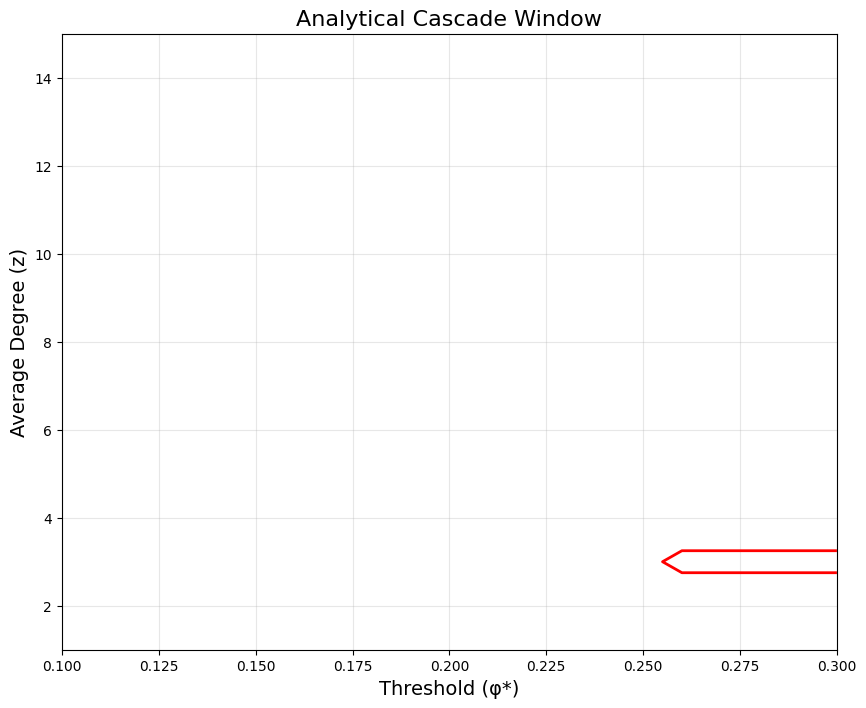

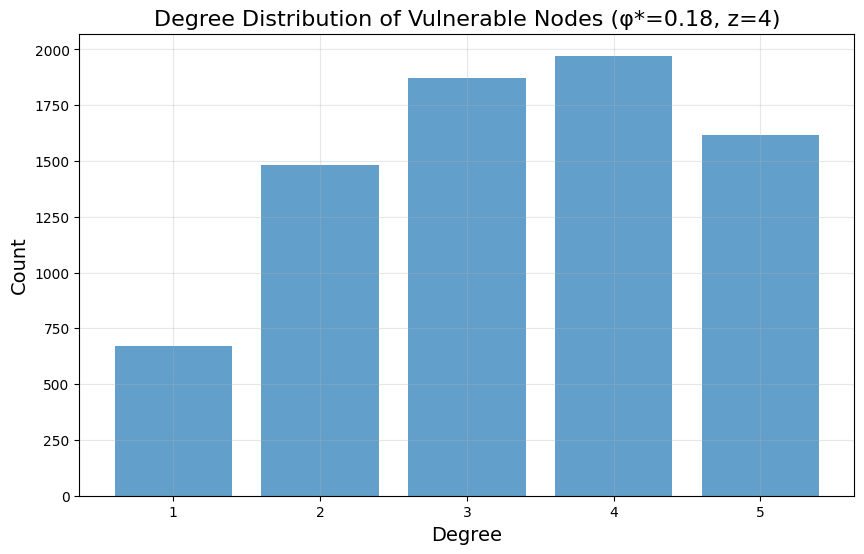

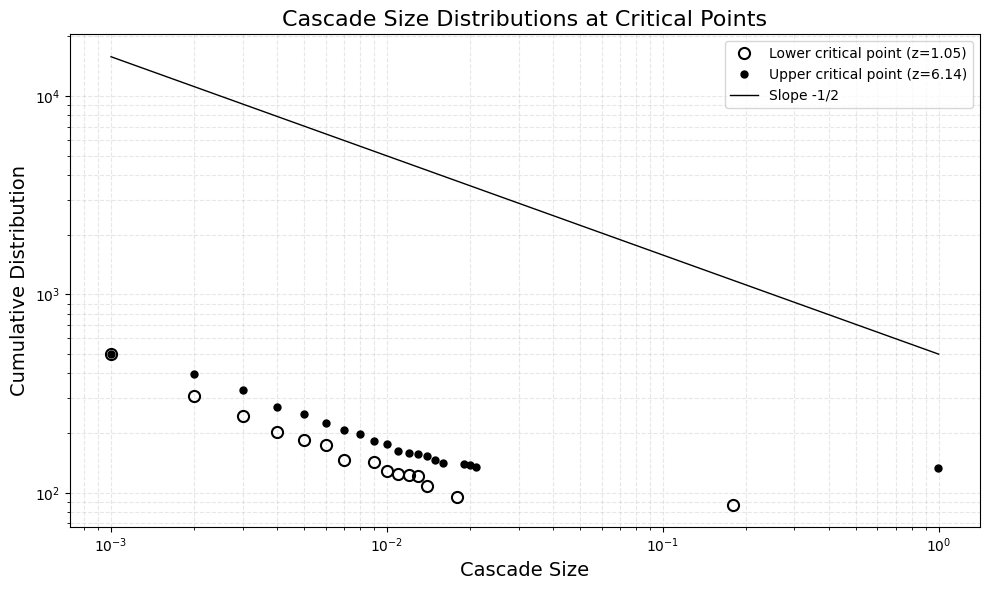

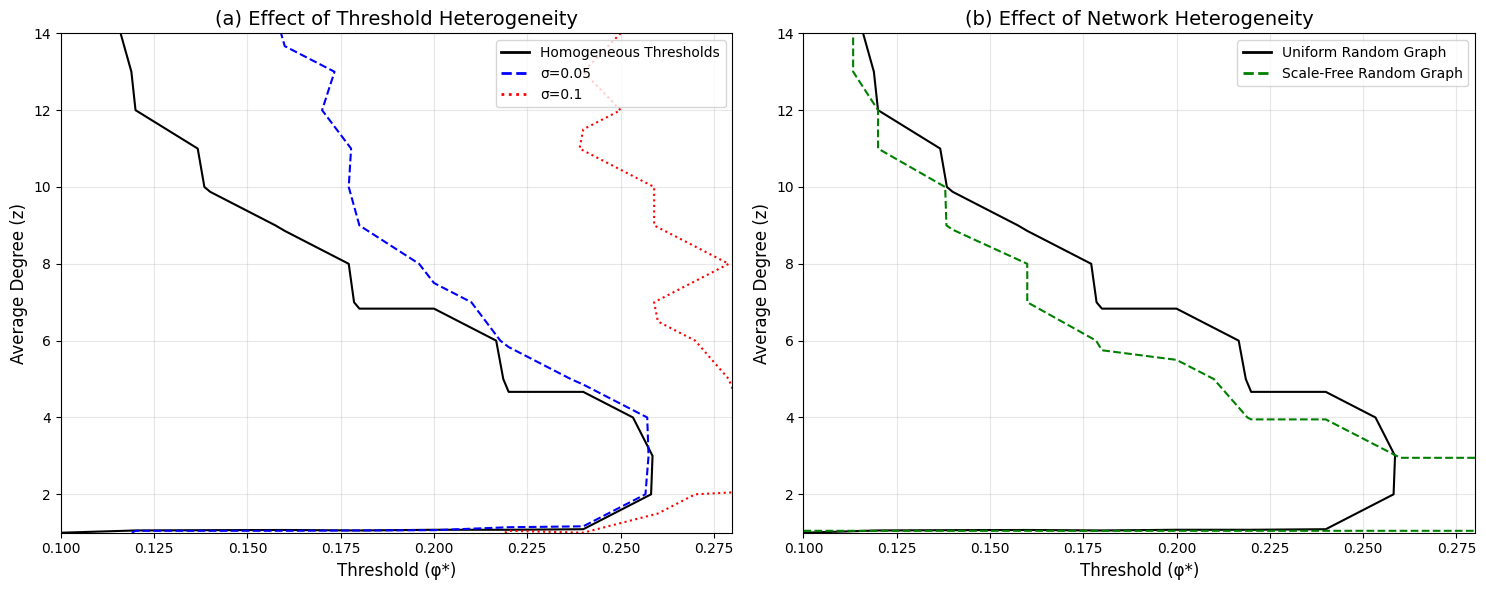

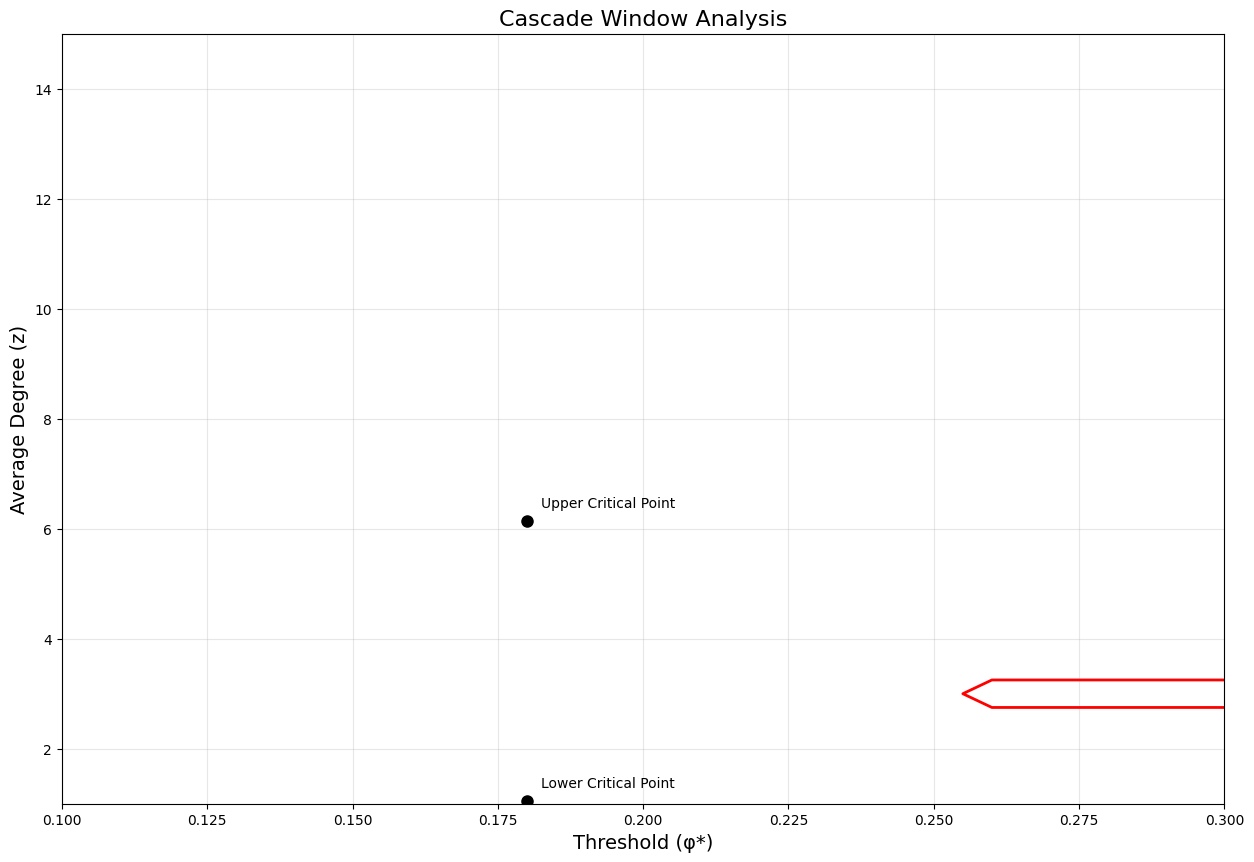

In [23]:

if __name__ == "__main__":
    # Run the full analysis or individual components as needed
    run_full_analysis()

##### I have coded using Object orientation and used tier 3 architecture. So, I converted all the files to single jupyter notebook. 
Git link is attached for the complete structure project. 
https://github.com/SaimAkramGill/CMSS 